In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

#Base.prepare(engine, reflect=True)
# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurements.date)).scalar()
print("The most recent date in the data set is:", most_recent_date)

The most recent date in the data set is: 2017-08-23


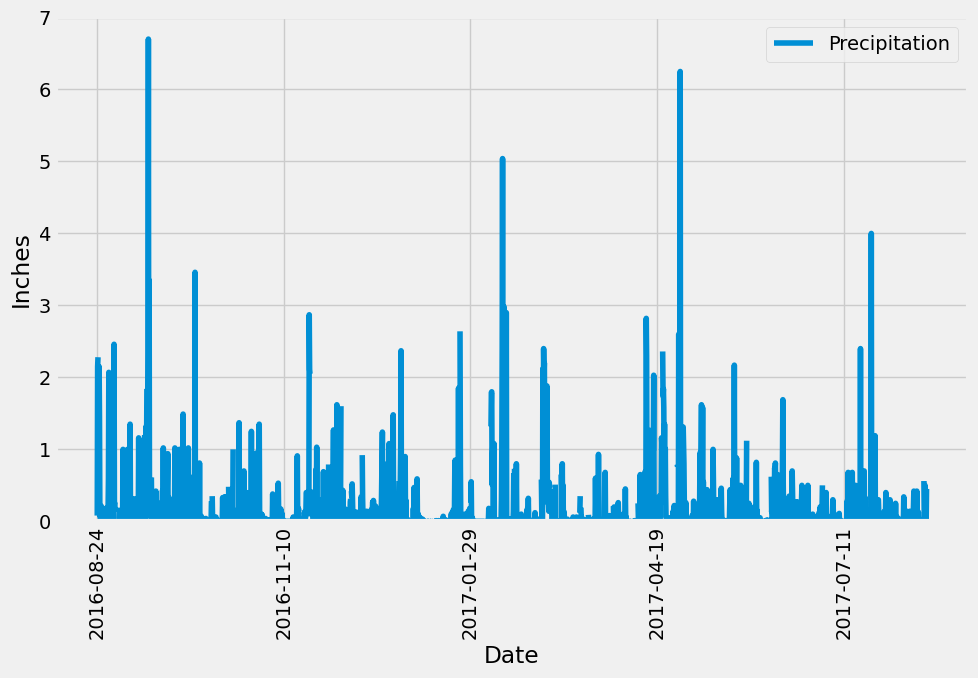

In [18]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
most_recent_date = session.query(func.max(Measurements.date)).scalar()
most_recent_date = dt.datetime.strptime(str(most_recent_date), '%Y-%m-%d')
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurements.date, Measurements.prcp)\
                  .filter(Measurements.date >= one_year_ago)\
                  .order_by(Measurements.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', rot=90, figsize=(10,7))
plt.ylim(0, 7)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()
plt.show()
# #2 method for future reference
#plt.plot(df['Date'], df['Precipitation'])
#plt.ylim(0, 7)
#plt.xticks(['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10'])
#plt.xlabel('Date')
#plt.ylabel('Inches')
#plt.xticks(rotation=45)

#plt.title('Precipitation')

#plt.tight_layout()
#plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df['Precipitation'].describe()
summary_stats_table = pd.DataFrame(summary_stats)
summary_stats_table
# Q1

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Stations.station)).scalar()
#result = [(total_stations,)]
print("Total number of stations:", total_stations)

Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurements.station, func.count(Measurements.station))\
                         .group_by(Measurements.station)\
                         .order_by(func.count(Measurements.station).desc())\
                         .all()


for station, count in active_stations:
    print([(station),(count)])

['USC00519281', 2772]
['USC00519397', 2724]
['USC00513117', 2709]
['USC00519523', 2669]
['USC00516128', 2612]
['USC00514830', 2202]
['USC00511918', 1979]
['USC00517948', 1372]
['USC00518838', 511]


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Identify the most active station
most_active_station = active_stations[0][0]

# Query to calculate lowest, highest, and average temperature for the most active station
temps = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs))\
              .filter(Measurements.station == most_active_station)\
              .all()

# Print the results
print([(temps[0][0], temps[0][1], temps[0][2])])

[(54.0, 85.0, 71.66378066378067)]


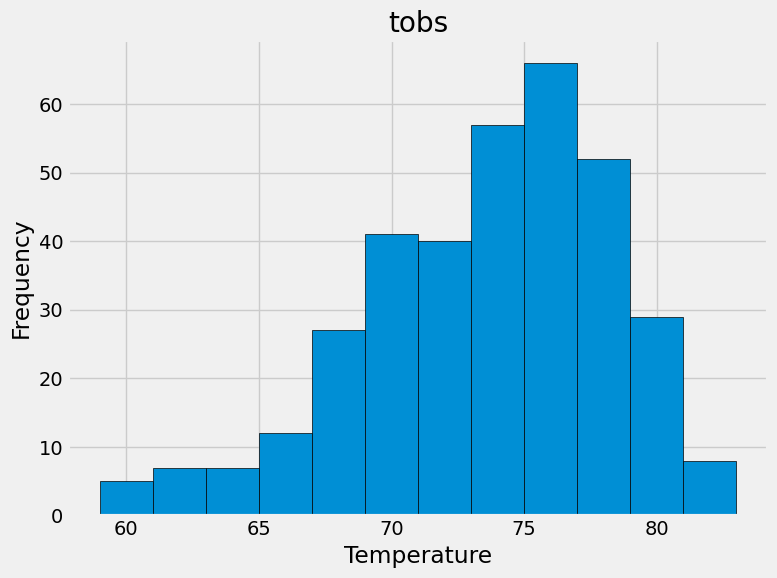

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_data = session.query(Measurements.tobs)\
                   .filter(Measurements.station == most_active_station)\
                   .filter(Measurements.date >= one_year_ago)\
                   .all()

# Convert the query results to a list
temps_list = [temp[0] for temp in temps_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temps_list, bins=12, edgecolor='black')
plt.title('tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()